# Network Models: Small World

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# plt.xkcd()
import networkx as nx
%matplotlib inline

During this seminar we will work with **Watts and Strogatz model**.
Again, the idea of the model:

1. Start with regular lattice with N nodes, K nearest neighbours
2. For each node take every edge and rewire it with probability $p$, assuming that there is no loops and edge duplications

##### Task

 1. Implement *rewind(G, p)* function that takes graph G and probability p as input. The function should produce a graph after step 2 of the model above. 
 2. Run experiments for various values of p, compute and show 
     * average path length 
     * clustering coefficients (transitivity) 
     * degree distribution     
 3. Compute centrality metrics for the [network](http://www-personal.umich.edu/~mejn/netdata/polblogs.zip) (including eigenvector, Katz, dispersion, local load centralities) and highlight interaction between vertices with the highest degree. Plot the interesting cases and interpret them.
 4. Try to model the network from (3) with Small World Model and Erdos-Renyi Model.
 5. Plot the dependencies between different centrality metrics for the network and the simultaed graphs. Are there any correlations between centrality metrics? Explain the differences.

In [128]:
def gen_regular_graph(n, k):
    G = nx.Graph()
    nodes = list(range(n))
    for j in range(1, k // 2+1):
        targets = nodes[j:] + nodes[0:j] # first j nodes are now last in list
        G.add_edges_from(zip(nodes,targets))
    return G

def degree_distr(k, bins = 'auto'):
    yh, binEdges = np.histogram(k, bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    return yh, bincenters

#### 1. Implement *rewind(G, p)* function that takes graph G and probability p as input. The function should produce a graph after step 2 of the model above.

The idea is to iterate over all the edges present in the given graph G, and to do the following with each of them:

* with probability p, change it so it would lead to different (chosen at random) node, while still connecting to the same first node; in other words, it is like treating the edge as a directed one, changing its end node, but preserving the start node.

Thus, the function will produce a graph of Watts and Strogatz model.

In [4]:
def rewind(G, p):
    """Return graph of Watts and Strogatz model"""
    edges = G.edges()
    # Take every edge and rewire it with probability p
    for i in edges:
        if np.random.random() < p:
            G.remove_edge(i[0], i[1]) # remove existing edge
            G.add_edge(i[0], np.random.randint(G.number_of_nodes())) # add new random edge in place of old edge
    return G

#### 2. Run experiments for various values of p, compute and show
- **average path length**
- **clustering coefficients (transitivity)**
- **degree distribution**

  p      average path length      clustering coefficient
--------------------------------------------------------
0.000           50.45                      0.67
0.050           5.39                      0.58
0.100           4.38                      0.47
0.150           4.11                      0.41
0.200           3.85                      0.33


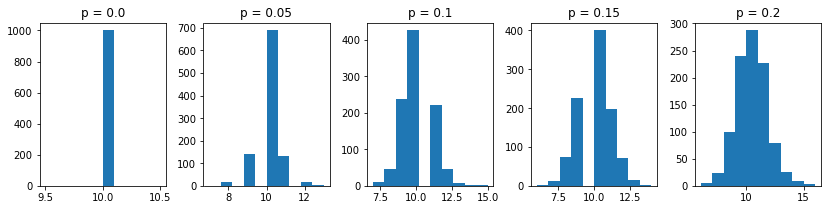

In [241]:
num_nodes = 1000 # number of nodes in a graph
degree = 10 # number of nearest neighbours for each node

plt.figure(1, figsize = (14, 3))
plt.subplots_adjust(wspace = 0.3)

print '  p      average path length      clustering coefficient'
print '--------------------------------------------------------'
steps = 5  # number of experiments with different p
max = 0.25 # maximum value of p

for step in np.arange(steps):
    p = max/steps*step # calculating the probability
    g = gen_regular_graph(num_nodes, degree) # creating the regular graph
    g = rewind(g, p) # applying the conversion to small world model
    apl = nx.average_shortest_path_length(g) # computing average path length
    cc = nx.transitivity(g) # computing clustering coefficient
    # printing results
    print '{0:.3f}           {1:.2f}                      {2:.2f}'.format(p, apl, cc)
        
    # plotting the distribution
    plt.subplot(1, steps, step + 1)
    plt.hist(g.degree().values())
    plt.title('p = ' + str(p))

We observe that with increasing probability p both average shortest path length and clustering coefficient decrease. The average path length shortens dramatically with just any perceptible p > 0. The reduction of clustering coefficient, while present, is not that drastic. The degree of nodes gradually disperses around initial value (10).

#### 3. Compute centrality metrics for the Political blogosphere network (including eigenvector, Katz, dispersion, local load centralities) and highlight interaction between vertices with the highest degree. Plot the interesting cases and interpret them.

In [6]:
# Loading the network
G = nx.read_gml(path = 'polblogs.gml')

Computing centrality metrics:

In [7]:
dc = nx.degree_centrality(G)

In [8]:
cl = nx.closeness_centrality(G)

In [9]:
bc = nx.betweenness_centrality(G)

In [10]:
# ec = nx.eigenvector_centrality(G)

In [11]:
# kc = nx.katz_centrality(G)

In [12]:
lc = nx.load_centrality(G)

Let's see what ranks did the node with the highest degree get in each metric. For that, we sort all nodes by each metric independently, and see what place does the node have.

We create a list of all the centrality metrics we computed and apply sorting to each element of the list. Thus we obtain a list of sorted metrics.

In [88]:
centralities = [dc, cl, bc, lc] # list of all centrality metrics
centrality_names = ['     degree centrality',
                    '  closeness centrality',
                    'betweenness centrality',
                    '       load centrality']

In [115]:
centralities_sorted = [] # list of sorted centrality metrics (descending)
for c in centralities:
    centralities_sorted.append(sorted(c.items(), key = lambda x: x[1], reverse = True))

Find the node with the highest degree. In fact, find the node with the second highest degree as well.

In [237]:
inverse = [(value, key) for key, value in G.degree().items()] # inversing the tuples of nodes and their degrees

# finding two greatest node degrees
m1, m2 = (0,0)
for i in inverse:
    if i > m1:
        m2 = m1
        m1 = i
        
max_degree_node = m1[1]
second_max = m2[1]
print 'Node {} has degree {}.'.format(max_degree_node, m1[0])
print 'Node {} has degree {}.'.format(second_max, m2[0])

Node 855 has degree 468.
Node 155 has degree 384.


Find where those nodes are in the metrics lists:

In [125]:
print 'Ranks of the node with the highest degree:\n'
for i in range(len(centralities)):
    node = next(j for j,x in enumerate(centralities_sorted[i]) if x[0] == max_degree_node)
    print '{0}: {1}'.format(centrality_names[i], node)

Ranks of the node with the highest degree:

     degree centrality: 0
  closeness centrality: 0
betweenness centrality: 0
       load centrality: 0


In [120]:
print 'Ranks of the node with the second highest degree:\n'
for i in range(len(centralities)):
    node = next(j for j,x in enumerate(centralities_sorted[i]) if x[0] == second_max)
    print '{0}: {1}'.format(centrality_names[i], node)

Ranks of the node with the second highest degree:

     degree centrality: 1
  closeness centrality: 388
betweenness centrality: 3
       load centrality: 3


We see that the node with the highest degree scores highest in all centrality metrics, while the node with the second highest degree follows it quite closely except in the **closeness centrality** metric.

#### 4. Try to model the network from (3) with Small World Model and Erdos-Renyi Model.

First we will see how the given network looks.

In [239]:
# Procedure to plot different types of plots for a graph

def plot_graph(G):
    # Calculating node degree distribution
    plt.figure(1, figsize = (11, 8))
    plt.subplots_adjust(wspace = 0.3, hspace = 0.4)

    y, x = degree_distr(G.degree().values())

    # Linear scale
    plt.subplot(221)
    plt.plot(x, y/float(len(y)), '.')
    plt.xlabel('Node degree')
    plt.ylabel('Probability')
    plt.title('Linear scale')

    # Linear binning
    plt.subplot(222)
    plt.loglog(x, y/float(len(y)), '.')
    plt.xlabel('Node degree (log)')
    plt.ylabel('Probability (log)')
    plt.title('Linear binning')

    # Log-binning
    bins = np.logspace(0, 10, base = 2.0)
    y, x = degree_distr(G.degree().values(), bins)

    plt.subplot(223)
    plt.loglog(x, y/float(len(y)), '.')
    plt.xlabel('Node degree (log)')
    plt.ylabel('Probability (log)')
    plt.title('Log-binning')

    # Rank-frequency plot
    k_sorted = sorted(G.degree().values(), reverse = True)
    r = np.arange(1, G.number_of_nodes() + 1)

    plt.subplot(224)
    plt.loglog(k_sorted, r/float(len(r)), '.')
    plt.xlabel('Node degrees (log)')
    plt.ylabel('Probability (log)')
    plt.title('Rank-frequency')

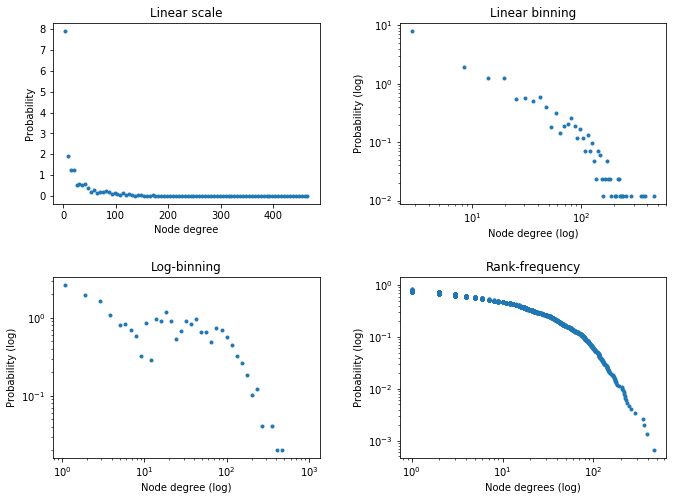

In [224]:
plot_graph(G)

Now we will try to model the network with Small World model.

In [234]:
n = G.number_of_nodes()
k = 2
p = 0.9

SW = gen_regular_graph(n, k) # creating the regular graph
SW = rewind(SW, p) # applying the conversion to small world model

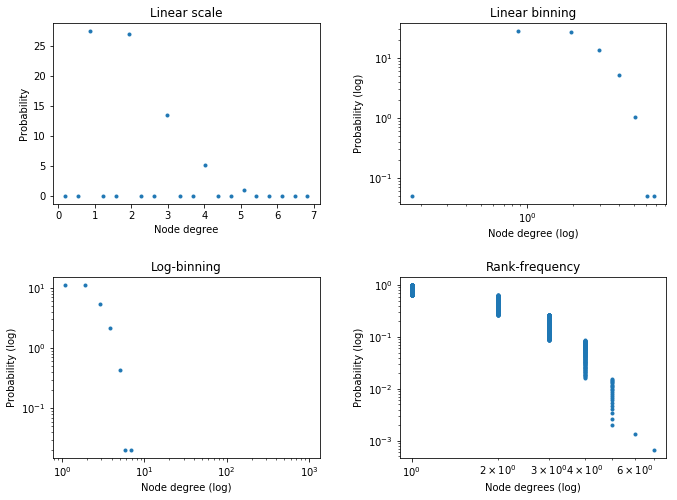

In [235]:
plot_graph(SW)

In [247]:
# Function to produce a random graph

def random_graph(n, p):
    G = nx.Graph()
    G.add_nodes_from(range(0,n))
    
    for i in xrange(0,n):
        for j in xrange(0,n):
            if np.random.random() <= p:
                G.add_edge(i,j)        
    return G

Attempt to model the network using random graph model.

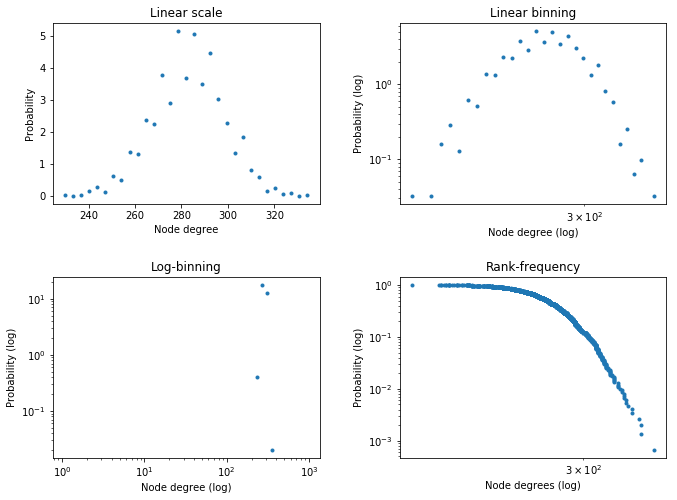

In [250]:
p = 0.1

RG = random_graph(n, p)
plot_graph(RG)